# Watershedding in 2 and 3D by initializing seeds using distance transform, starting with Gaussian Blur in 2 and 3D, compare plotting functions, identify code that can be put in a local .py file instead of being a part of Jupyter notebook enviornment


Import packages to open and view tiffile, other python packages to deal with loading images from a certain directory. For writting results we need to create another directory, this is done by pathlib

In [1]:
from tifffile import imread
import matplotlib.pyplot as plt
import os
import glob
import numpy as np
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import Range1d
try:
    from pathlib import Path
    Path().expanduser()
except (ImportError, AttributeError):
        from pathlib2 import Path

try:
        import tempfile
        tempfile.TemporaryDirectory
except (ImportError, AttributeError):
       from backports import tempfile
from scipy import ndimage as ndi
from skimage.filters import roberts, sobel, scharr, prewitt, gaussian
from skimage.morphology import watershed
from skimage.feature import peak_local_max, canny

from skimage.segmentation import find_boundaries,find_boundaries, relabel_sequential
from skimage.morphology import remove_small_objects, binary_erosion
from skimage.filters import threshold_otsu, threshold_mean
from skimage.exposure import rescale_intensity
from skimage import data, io


from skimage.morphology import remove_small_objects, binary_erosion

Now specify the source directory path, results directory path. Even if the results directory does not exist we can create one using Pathlib functions. The os function joins all the tif files found in the source directory. Also specify the axes of the images in the directory, if you have images of different axes in the same directory you will have to specify it seperately for each one of them when needed, else a good practise woulöd be to keep the same axes images in the same directory.

In [2]:
sourcedir = '/Users/aimachine/sample_images_python/'
resultsdir = '/Users/aimachine/sample_images_python/Results/'
Path(resultsdir).mkdir(exist_ok = True)
Raw_path = os.path.join(sourcedir, '*tif')
X = glob.glob(Raw_path)
axes = 'ZYX'

Write the names of the tif files found in the directory and the shape of images. Shape is a keyword in Python used to indicate the dimensions along each axis, For example it could be 100 time points, 3 channels, and 500 by 400 XY dimensions. In such case the shape would be (100,3,500,400) (Be careful about XY axes, sometimes they may appear be YX instead of XY, so a rotated image of the original image)

In [3]:
All4Dimages = []
All5Dimages = []
for fname in X:

    image = imread(fname)
    if len(image.shape) == 4:
        All4Dimages.append(image)
    if len(image.shape) > 4:
        All5Dimages.append(image)
    
    print(fname, image.shape, len(image.shape), len(All4Dimages), len(All5Dimages))

/Users/aimachine/sample_images_python/190709_wt_longtemTL_3.tif (100, 3, 535, 412) 4 1 0
/Users/aimachine/sample_images_python/190709_wt_longtemTL_4.tif (100, 3, 437, 366) 4 2 0
/Users/aimachine/sample_images_python/190905_e2_MyoGFP_mTmG-python.tif (5, 31, 2, 1093, 1107) 5 2 1
/Users/aimachine/sample_images_python/191018_DAPI_aPKCz_AQ3_Phall_wt1.tif (124, 4, 1109, 1109) 4 3 1


Choose the image with TZCYX shape and let us process each time-point at a time

In [100]:
for i in range(0, len(All5Dimages)):
    
    FiveDimage = All5Dimages[i]
    print(FiveDimage.shape)
    for time in range(0, FiveDimage.shape[0]):
        FourDimage = FiveDimage[time,:]
        if time == 0:
          print(FourDimage.shape)
        #Select a channel 
        channel = 1
        ThreeDimage = FourDimage[:,channel,:]
        if time == 0:
            print(ThreeDimage.shape)
            
    # Take care of the intendation       
    # Now we apply Gaussian Blur is a 3D Blur
    blur_radius = 2
    BlurredThreeDimage = gaussian(ThreeDimage, blur_radius)
    TwoDBlurredThreeDimage = np.zeros([ThreeDimage.shape[0],ThreeDimage.shape[1], ThreeDimage.shape[2]]) 
    for j in range(0, ThreeDimage.shape[0]):
        # Now lets try 2D Gaussian Blur
        TwoDBlurredThreeDimage[j,:] = gaussian(ThreeDimage[j,:], blur_radius)
        
        #Since we have only one iamge we go out of the loop now

(5, 31, 2, 1093, 1107)
(31, 2, 1093, 1107)
(31, 1093, 1107)


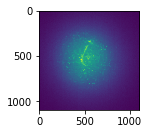

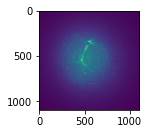

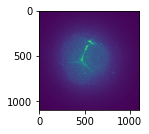

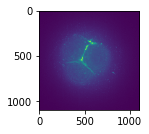

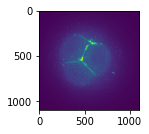

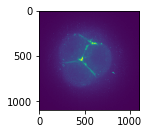

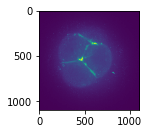

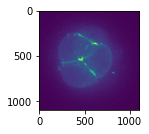

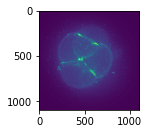

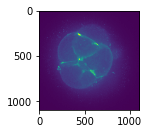

In [101]:
for j in range(0, BlurredThreeDimage.shape[0]):
   if j < 10: 
    #Ugly
    plt.figure()
    plt.subplot(2,2, 1)
    plt.imshow(BlurredThreeDimage[j,:])

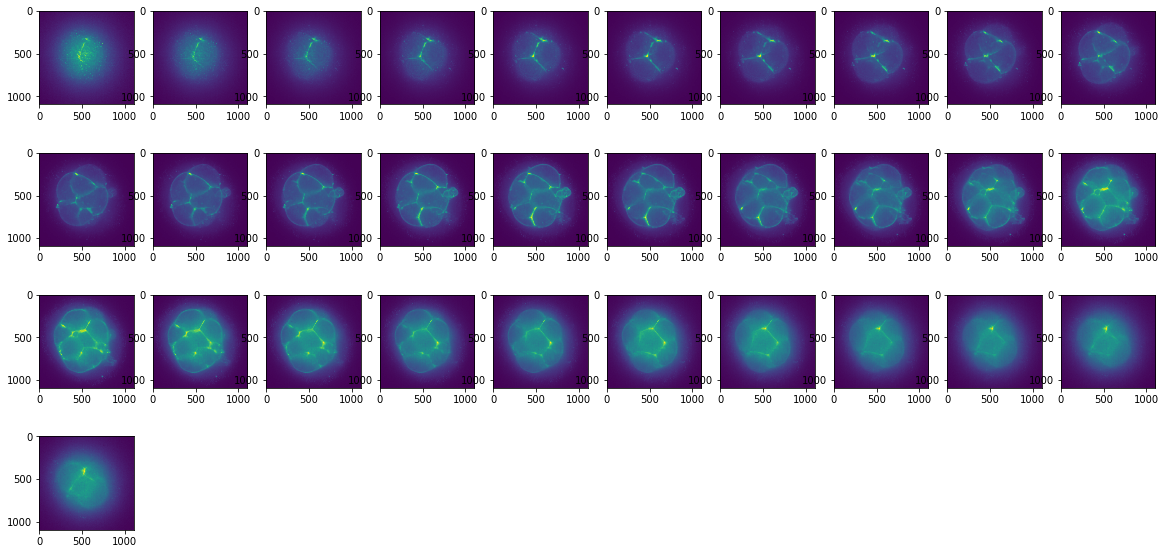

In [102]:
#Non Ugly way using subplot
cols = 10
plt.figure(figsize = (20,10))
TotalTimePoints = BlurredThreeDimage.shape[0]
for j in range(0, TotalTimePoints):
        plt.subplot(TotalTimePoints/cols + 1 , cols, j + 1 )      
        plt.imshow(BlurredThreeDimage[j,:])

A very ugly function that should be in a spyder editor written code instead of jupyter notebook like we are doing now

In [103]:
import collections

import warnings
from tifffile import imsave
# https://docs.python.org/3/library/itertools.html#itertools-recipes
def move_image_axes(x, fr, to, adjust_singletons=False):
    """
    x: ndarray
    fr,to: axes string (see `axes_dict`)
    """
    fr = axes_check_and_normalize(fr, length=x.ndim)
    to = axes_check_and_normalize(to)

    fr_initial = fr
    x_shape_initial = x.shape
    adjust_singletons = bool(adjust_singletons)
    if adjust_singletons:
        # remove axes not present in 'to'
        slices = [slice(None) for _ in x.shape]
        for i,a in enumerate(fr):
            if (a not in to) and (x.shape[i]==1):
                # remove singleton axis
                slices[i] = 0
                fr = fr.replace(a,'')
        x = x[slices]
        # add dummy axes present in 'to'
        for i,a in enumerate(to):
            if (a not in fr):
                # add singleton axis
                x = np.expand_dims(x,-1)
                fr += a

    if set(fr) != set(to):
        _adjusted = '(adjusted to %s and %s) ' % (x.shape, fr) if adjust_singletons else ''
        raise ValueError(
            'image with shape %s and axes %s %snot compatible with target axes %s.'
            % (x_shape_initial, fr_initial, _adjusted, to)
        )

    ax_from, ax_to = axes_dict(fr), axes_dict(to)
    if fr == to:
        return x
    return np.moveaxis(x, [ax_from[a] for a in fr], [ax_to[a] for a in fr])
def consume(iterator):
    collections.deque(iterator, maxlen=0)


def compose(*funcs):
    return lambda x: reduce(lambda f,g: g(f), funcs, x)

def axes_check_and_normalize(axes,length=None,disallowed=None,return_allowed=False):
    """
    S(ample), T(ime), C(hannel), Z, Y, X
    """
    allowed = 'STCZYX'
    axes = str(axes).upper()
    consume(a in allowed or _raise(ValueError("invalid axis '%s', must be one of %s."%(a,list(allowed)))) for a in axes)
    disallowed is None or consume(a not in disallowed or _raise(ValueError("disallowed axis '%s'."%a)) for a in axes)
    consume(axes.count(a)==1 or _raise(ValueError("axis '%s' occurs more than once."%a)) for a in axes)
    length is None or len(axes)==length or _raise(ValueError('axes (%s) must be of length %d.' % (axes,length)))
    return (axes,allowed) if return_allowed else axes

def axes_dict(axes):
    """
    from axes string to dict
    """
    axes, allowed = axes_check_and_normalize(axes,return_allowed=True)
    return { a: None if axes.find(a) == -1 else axes.find(a) for a in allowed }
    # return collections.namedtuple('Axes',list(allowed))(*[None if axes.find(a) == -1 else axes.find(a) for a in allowed ])
    
def save_tiff_imagej_compatible(file, img, axes, **imsave_kwargs):
    """Save image in ImageJ-compatible TIFF format.

    Parameters
    ----------
    file : str
        File name
    img : numpy.ndarray
        Image
    axes: str
        Axes of ``img``
    imsave_kwargs : dict, optional
        Keyword arguments for :func:`tifffile.imsave`

    """
    axes = axes_check_and_normalize(axes,img.ndim,disallowed='S')

    # convert to imagej-compatible data type
    t = img.dtype
    if   'float' in t.name: t_new = np.float32
    elif 'uint'  in t.name: t_new = np.uint16 if t.itemsize >= 2 else np.uint8
    elif 'int'   in t.name: t_new = np.int16
    else:                   t_new = t
    img = img.astype(t_new, copy=False)
    if t != t_new:
        warnings.warn("Converting data type from '%s' to ImageJ-compatible '%s'." % (t, np.dtype(t_new)))

    # move axes to correct positions for imagej
        img = move_image_axes(img, axes, 'TZCYX', True)

    imsave_kwargs['imagej'] = True
    imsave(file, img, **imsave_kwargs)

# Normalize images before morphological operations

In [104]:
def NormalizeFloat(x, pmin=3, pmax=99.8, axis=None, clip=False, eps=1e-20, dtype=np.float32):
    """Percentile-based image normalization."""

    mi = np.percentile(x,pmin,axis=axis,keepdims=True)
    ma = np.percentile(x,pmax,axis=axis,keepdims=True)
    return normalize_mi_ma(x, mi, ma, clip=clip, eps=eps, dtype=dtype)


def normalize_mi_ma(x, mi, ma, clip=False, eps=1e-20, dtype=np.float32):
    if dtype is not None:
        x   = x.astype(dtype,copy=False)
        mi  = dtype(mi) if np.isscalar(mi) else mi.astype(dtype,copy=False)
        ma  = dtype(ma) if np.isscalar(ma) else ma.astype(dtype,copy=False)
        eps = dtype(eps)

    try:
        import numexpr
        x = numexpr.evaluate("(x - mi) / ( ma - mi + eps )")
    except ImportError:
        x =                   (x - mi) / ( ma - mi + eps )

    if clip:
        x = np.clip(x,0,1)

    return x

In [105]:
for j in range(0, TotalTimePoints):
  BlurredThreeDimage[j,:] = NormalizeFloat(BlurredThreeDimage[j,:], 1, 99.8)
  TwoDBlurredThreeDimage[j,:] = NormalizeFloat(TwoDBlurredThreeDimage[j,:], 1, 99.8)

In [106]:
#Save the Blurred image in results directory
save_tiff_imagej_compatible((resultsdir + "Blur" + '.tif') , BlurredThreeDimage, axes)
save_tiff_imagej_compatible((resultsdir + "2DBlur" + '.tif') ,TwoDBlurredThreeDimage, axes)

/Users/aimachine/miniconda3/envs/tensorflowEnv36/lib/python3.6/site-packages/ipykernel_launcher.py:96: UserWarning: Converting data type from 'float64' to ImageJ-compatible 'float32'.
/Users/aimachine/miniconda3/envs/tensorflowEnv36/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


# Do Distance transform on 3D and 2D slice by slice blurred image

In [107]:
#Make Binary image using Otsu threshold by first enhancing the edges using canny edge detection
TotalTimePoints = BlurredThreeDimage.shape[0]
ThreeDedge= np.zeros([BlurredThreeDimage.shape[0],BlurredThreeDimage.shape[1], BlurredThreeDimage.shape[2]])
TwoDThreeDedge = np.zeros([BlurredThreeDimage.shape[0],BlurredThreeDimage.shape[1], BlurredThreeDimage.shape[2]])
ThreeDbinary = np.zeros([BlurredThreeDimage.shape[0],BlurredThreeDimage.shape[1], BlurredThreeDimage.shape[2]]) 
TwoDThreeDbinary = np.zeros([BlurredThreeDimage.shape[0],BlurredThreeDimage.shape[1], BlurredThreeDimage.shape[2]]) 
ThreeDdistance = np.zeros([BlurredThreeDimage.shape[0],BlurredThreeDimage.shape[1], BlurredThreeDimage.shape[2]]) 
TwoDBlurThreeDdistance = np.zeros([BlurredThreeDimage.shape[0],BlurredThreeDimage.shape[1], BlurredThreeDimage.shape[2]]) 


for j in range(0, TotalTimePoints):
 ThreeDedge[j,:] = canny(BlurredThreeDimage[j,:], sigma = 3)
 
 ThreeDthresh = threshold_otsu(ThreeDedge[j,:])
 ThreeDbinary[j,:] = ThreeDedge[j,:] > ThreeDthresh
  
 TwoDThreeDedge[j,:] = canny(TwoDBlurredThreeDimage[j,:], sigma = 3)
 TwoDThreeDthresh = threshold_otsu(TwoDThreeDedge[j,:])
 TwoDThreeDbinary[j,:] = TwoDThreeDedge[j,:] > TwoDThreeDthresh
     
    

 #Do the distance transform and compare the two Blurring methods
 ThreeDdistance[j,:] = ndi.distance_transform_edt(np.logical_not((ThreeDbinary[j,:].astype('uint8'))))
 TwoDBlurThreeDdistance[j,:] = ndi.distance_transform_edt(np.logical_not((TwoDThreeDbinary[j,:].astype('uint8'))))  


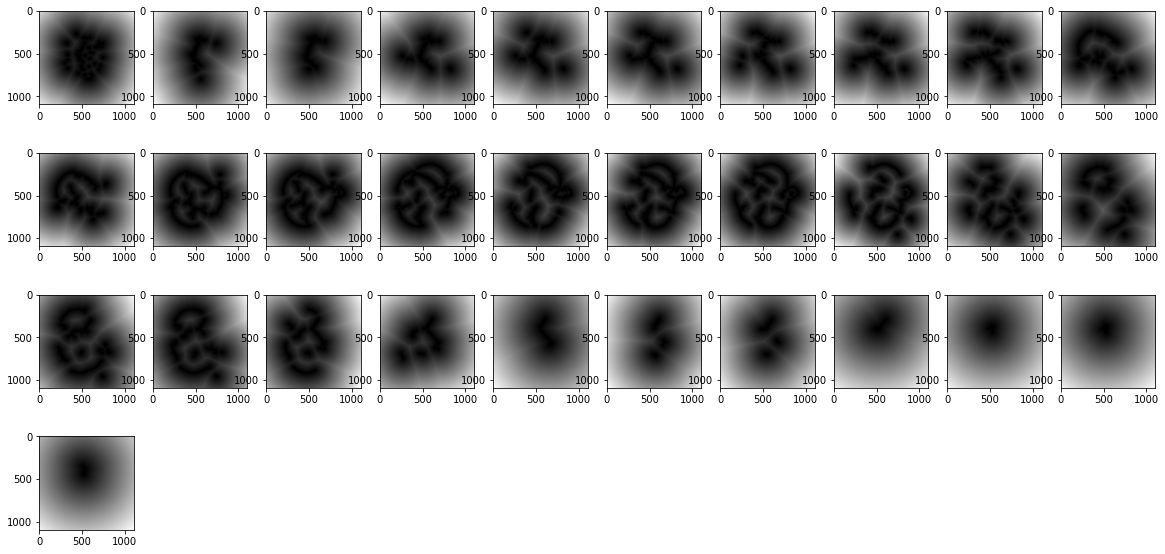

In [108]:
cols = 10
plt.figure(figsize = (20,10))
TotalTimePoints = ThreeDdistance.shape[0]
for j in range(0, TotalTimePoints):
        plt.subplot(TotalTimePoints/cols + 1 , cols, j + 1 )      
        plt.imshow(ThreeDdistance[j,:] , cmap=plt.cm.gray)

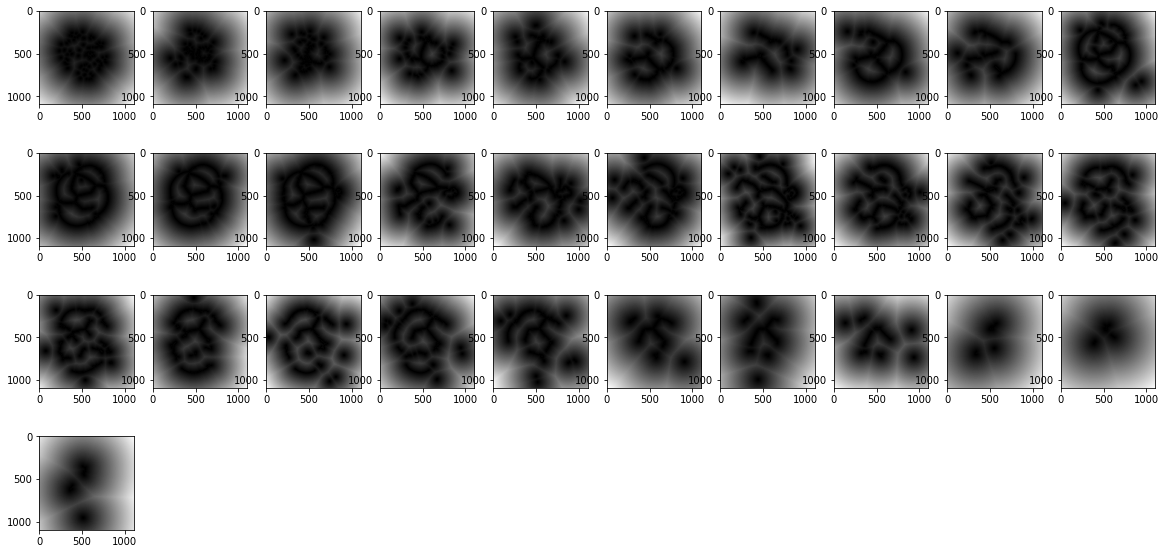

In [109]:
cols = 10
plt.figure(figsize = (20,10))
TotalTimePoints = TwoDBlurThreeDdistance.shape[0]
for j in range(0, TotalTimePoints):
        plt.subplot(TotalTimePoints/cols + 1 , cols, j + 1 )      
        plt.imshow(TwoDBlurThreeDdistance[j,:], cmap=plt.cm.gray)

In [110]:
#Save the slice by slice distance transformed image in results directory
save_tiff_imagej_compatible((resultsdir + "DistTransform" + '.tif') ,  ThreeDdistance, axes)
save_tiff_imagej_compatible((resultsdir + "2DBlurDistTransform" + '.tif') ,TwoDBlurThreeDdistance, axes)

/Users/aimachine/miniconda3/envs/tensorflowEnv36/lib/python3.6/site-packages/ipykernel_launcher.py:96: UserWarning: Converting data type from 'float64' to ImageJ-compatible 'float32'.
/Users/aimachine/miniconda3/envs/tensorflowEnv36/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


# Trying 3D watershed

In [111]:

local_maxi = peak_local_max(np.logical_not(ThreeDdistance), indices=False, footprint=np.ones((1, 1, 1)),
                            labels=ThreeDbinary)

markers = ndi.label(local_maxi)[0]
labels = watershed(-ThreeDdistance, markers, mask=ThreeDbinary)


nonormimg = remove_small_objects(labels, min_size=10, connectivity=4, in_place=False)
nonormimg, forward_map, inverse_map = relabel_sequential(nonormimg)    
labels = nonormimg

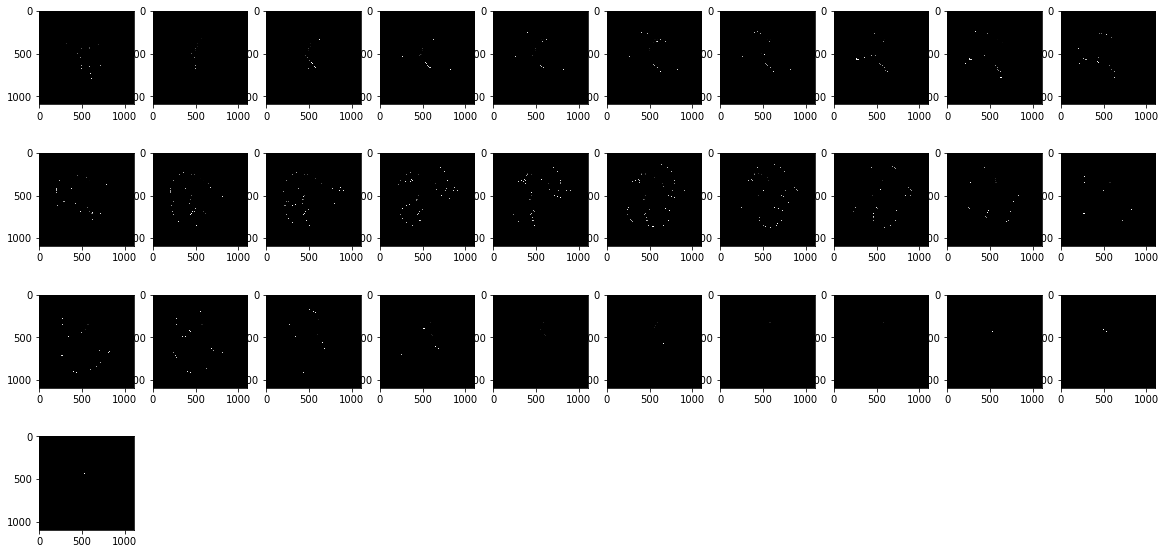

In [112]:
cols = 10
plt.figure(figsize = (20,10))
TotalTimePoints = labels.shape[0]
for j in range(0, TotalTimePoints):
        plt.subplot(TotalTimePoints/cols + 1 , cols, j + 1 )      
        plt.imshow(labels[j,:], cmap=plt.cm.gray)

In [113]:

local_maxi_second = peak_local_max(np.logical_not(TwoDBlurThreeDdistance), indices=False, footprint=np.ones((3, 3, 3)),
                            labels=TwoDThreeDbinary)
markers_second = ndi.label(local_maxi_second)[0]
labels_second = watershed(TwoDBlurThreeDdistance, markers_second, mask=TwoDThreeDbinary)


nonormimg_second = remove_small_objects(labels_second, min_size=10, connectivity=4, in_place=False)
nonormimg_second, forward_map_second, inverse_map_second = relabel_sequential(nonormimg_second)    
labels_second = nonormimg_second

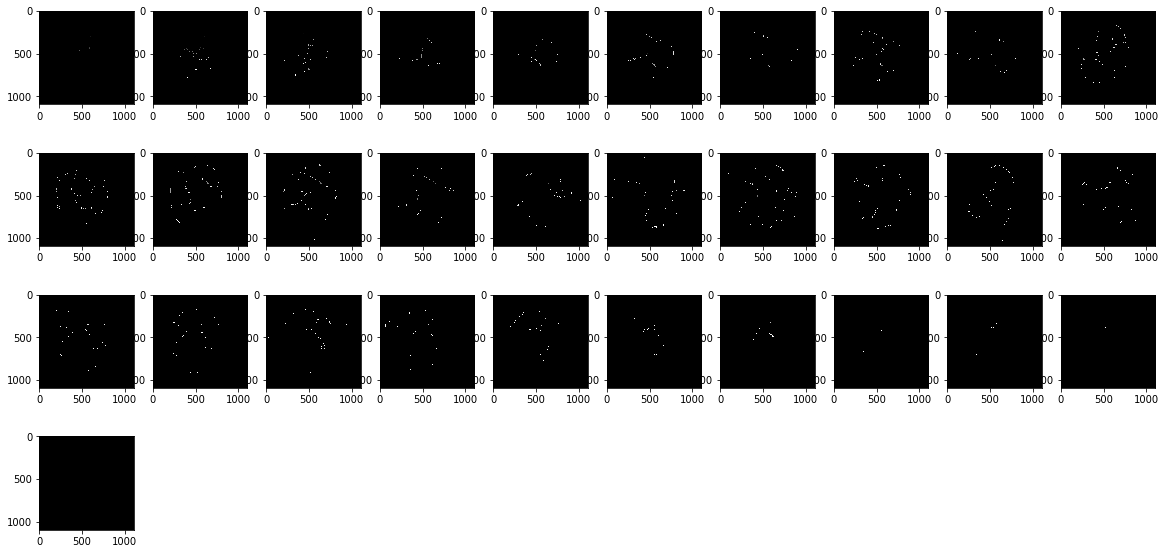

In [114]:
cols = 10
plt.figure(figsize = (20,10))
TotalTimePoints = labels_second.shape[0]
for j in range(0, TotalTimePoints):
        plt.subplot(TotalTimePoints/cols + 1 , cols, j + 1 )      
        plt.imshow(labels_second[j,:], cmap=plt.cm.gray)

In [115]:
#Save the slice by slice distance transformed image in results directory
save_tiff_imagej_compatible((resultsdir + "Watershed" + '.tif') ,  labels, axes)
save_tiff_imagej_compatible((resultsdir + "2DBlurWatershed" + '.tif') ,labels_second, axes)

/Users/aimachine/miniconda3/envs/tensorflowEnv36/lib/python3.6/site-packages/ipykernel_launcher.py:96: UserWarning: Converting data type from 'int64' to ImageJ-compatible 'int16'.
/Users/aimachine/miniconda3/envs/tensorflowEnv36/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


In [116]:
print(type(local_maxi))

<class 'numpy.ndarray'>


# Trying 2D watershed

In [117]:
local_maxi = np.zeros([BlurredThreeDimage.shape[0],BlurredThreeDimage.shape[1], BlurredThreeDimage.shape[2]])
markers = np.zeros([BlurredThreeDimage.shape[0],BlurredThreeDimage.shape[1], BlurredThreeDimage.shape[2]])
labels = np.zeros([BlurredThreeDimage.shape[0],BlurredThreeDimage.shape[1], BlurredThreeDimage.shape[2]])
for j in range(0, TotalTimePoints):
 local_maxi[j,:] = peak_local_max((ThreeDdistance[j,:]), indices=False, footprint=np.ones((3, 3)),
                            labels=ThreeDbinary[j,:])
 
 markers[j,:] = ndi.label(local_maxi[j,:])[0]
    
 labels[j,:] = watershed(-ThreeDdistance[j,:], markers[j,:], mask=ThreeDbinary[j,:])


 nonormimg = remove_small_objects(labels[j,:].astype('uint8'), min_size=10, connectivity=4, in_place=False)
 nonormimg, forward_map, inverse_map = relabel_sequential(nonormimg[j,:])    
 labels[j,:] = nonormimg

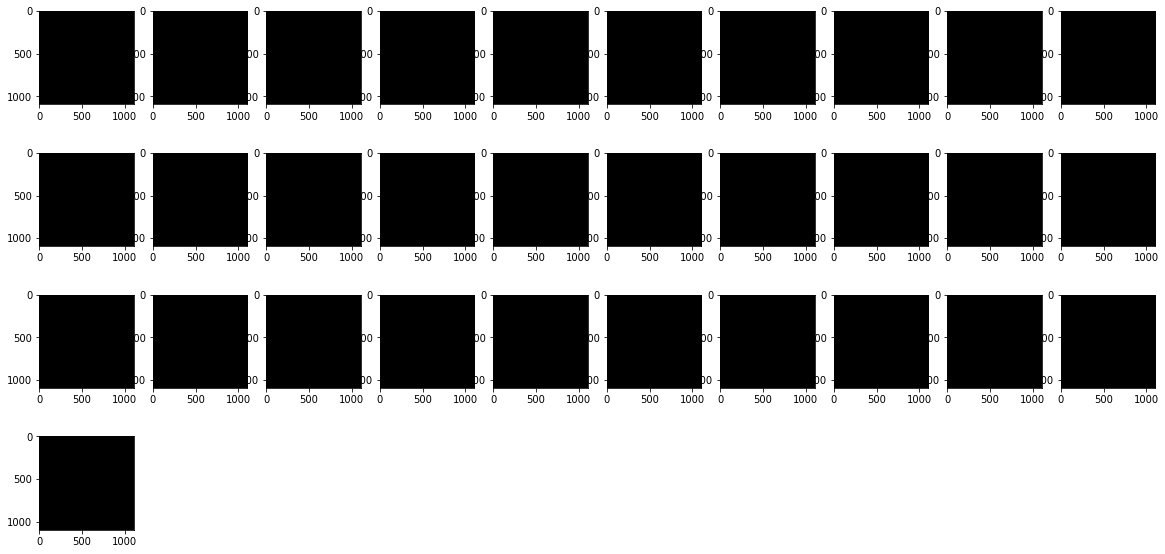

In [118]:
cols = 10
plt.figure(figsize = (20,10))
TotalTimePoints = labels.shape[0]
for j in range(0, TotalTimePoints):
        plt.subplot(TotalTimePoints/cols + 1 , cols, j + 1 )      
        plt.imshow(labels[j,:], cmap=plt.cm.gray)

In [ ]:
local_maxi_second = np.zeros([BlurredThreeDimage.shape[0],BlurredThreeDimage.shape[1], BlurredThreeDimage.shape[2]])
markers_second = np.zeros([BlurredThreeDimage.shape[0],BlurredThreeDimage.shape[1], BlurredThreeDimage.shape[2]])
labels_second = np.zeros([BlurredThreeDimage.shape[0],BlurredThreeDimage.shape[1], BlurredThreeDimage.shape[2]])
for j in range(0, TotalTimePoints):
 local_maxi_second[j,:] = peak_local_max((ThreeDdistance[j,:]), indices=False, footprint=np.ones((3, 3)),
                            labels=ThreeDbinary[j,:])
 
 markers_second[j,:] = ndi.label(local_maxi_second[j,:])[0]
    
 labels_second[j,:] = watershed(-ThreeDdistance[j,:], markers_second[j,:], mask=ThreeDbinary[j,:])


 nonormimg_second = remove_small_objects(labels[j,:].astype('uint8'), min_size=10, connectivity=4, in_place=False)
 nonormimg_second, forward_map_second, inverse_map_second = relabel_sequential(nonormimg[j,:])    
 labels_second[j,:] = nonormimg_second

In [119]:
save_tiff_imagej_compatible((resultsdir + "TwoDimensionalWatershed" + '.tif') ,  labels, axes)
save_tiff_imagej_compatible((resultsdir + "2DBlurTwoDimensionalWatershed" + '.tif') ,  labels_second, axes)

/Users/aimachine/miniconda3/envs/tensorflowEnv36/lib/python3.6/site-packages/ipykernel_launcher.py:96: UserWarning: Converting data type from 'float64' to ImageJ-compatible 'float32'.
/Users/aimachine/miniconda3/envs/tensorflowEnv36/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
